# Diagnosing Respiratory and Chest Diseases from X-rays Using Deep Learning

This notebook implements a CNN-based classification of chest X-rays for pneumonia detection.

## 1. Setup and Import Libraries

In [1]:
import os
import json
import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2025-05-28 20:55:45.342058: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748458545.368072    1348 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748458545.376085    1348 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748458545.422427    1348 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748458545.422442    1348 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748458545.422443    1348 computation_placer.cc:177] computation placer alr

## 2. Configuration Parameters

Define all configurable parameters in one place for easier experimentation.

In [2]:
# Experiment configuration
base_path = "./datasets/2/chest_xray"

config = {
    "experiment_name": "vgg_17e_with_class_weights",
    "data": {
        "train_dir": base_path + "/train_256x256",
        "val_dir": base_path + "/val_256x256",
        "test_dir": base_path + "/test_256x256",
        "img_size": [
            256,
            256
        ],
        "batch_size": 8
    },
    "model": {
        "name": "vgg_like",
        "input_shape": [
            256,
            256,
            3
        ],
        "use_class_weights": True
    },
    "training": {
        "learning_rate": 5e-05,
        "epochs": 17,
        "use_early_stopping": True,
        "early_stopping_patience": 3
    },
    "results_dir": "experiment_results"
}

# Create results directory if it doesn't exist
experiment_dir = os.path.join(config["results_dir"], config["experiment_name"] + "_" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S"))
os.makedirs(experiment_dir, exist_ok=True)
print(f"Results will be saved to: {experiment_dir}")

# Save configuration
with open(os.path.join(experiment_dir, "config.json"), "w") as f:
    json.dump(config, f, indent=4)

Results will be saved to: experiment_results/vgg_17e_with_class_weights_20250528_205555


## 3. Data Loading and Preprocessing

Setup ImageDataGenerator for loading and preprocessing images.

In [3]:
# Data directories
train_dir = config["data"]["train_dir"]
val_dir = config["data"]["val_dir"]
test_dir = config["data"]["test_dir"]

# Image parameters
img_size = config["data"]["img_size"]
batch_size = config["data"]["batch_size"]

# Basic preprocessing (rescaling)
datagen = ImageDataGenerator(rescale=1./255)

# Train generator (consider adding augmentation here if needed)
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Validation generator
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Test generator
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Don't shuffle test data to maintain order for evaluation
)

# Class names
class_names = list(train_generator.class_indices.keys())
print(f"Classes: {class_names}")

# Dataset sizes
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")

Found 8782 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.
Found 1760 images belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']
Training samples: 8782
Validation samples: 1170
Test samples: 1760


## 4. Model Architecture Definition

Define different model architectures that can be selected via configuration.

In [4]:
def build_basic_cnn(config):
    """Build a basic CNN model based on the provided configuration"""
    model = Sequential()
    
    # Input layer and first convolutional block
    model.add(Conv2D(config["model"]["conv_layers"][0], (3, 3), activation='relu', 
                     input_shape=config["model"]["input_shape"]))
    model.add(MaxPooling2D(2, 2))
    
    # Additional convolutional blocks
    for filters in config["model"]["conv_layers"][1:]:
        model.add(Conv2D(filters, (3, 3), activation='relu'))
        model.add(MaxPooling2D(2, 2))
    
    # Flatten and dense layers
    model.add(Flatten())
    model.add(Dropout(config["model"]["dropout_rate"]))
    
    # Dense hidden layers
    for units in config["model"]["dense_layers"]:
        model.add(Dense(units, activation='relu'))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    
    return model

def build_deeper_cnn(config):
    """Build a deeper CNN with more layers and filters"""
    model = Sequential()
    
    # First block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', 
                     input_shape=config["model"]["input_shape"]))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(2, 2))
    
    # Second block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(2, 2))
    
    # Third block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(2, 2))
    
    # Fourth block
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(2, 2))
    
    # Flatten and dense layers
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

def build_vgg_like(config):
    """Build a VGG-style CNN with blocks of convolutional layers"""
    model = Sequential()
    
    model.add(Input(shape=config["model"]["input_shape"]))
    
    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Fully connected layers
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

def build_custom_cnn(config):
    """Build a custom CNN"""
    model = Sequential()
    
    model.add(Input(shape=config["model"]["input_shape"]))
    model.add(Conv2D(32, (3, 3), strides=1, activation='relu', padding='same'))
    
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
    
    model.add(Conv2D(64, (3, 3), strides=1, activation='relu', padding='same'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
    
    model.add(Conv2D(128, (3, 3), strides=1, activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
    
    model.add(Conv2D(256, (3, 3), strides=1, activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

# Model factory to select architecture based on configuration
def get_model(config):
    model_name = config["model"]["name"]
    if model_name == "basic_cnn":
        return build_basic_cnn(config)
    elif model_name == "deeper_cnn":
        return build_deeper_cnn(config)
    elif model_name == "vgg_like":
        return build_vgg_like(config)
    elif model_name == "custom_cnn":
        return build_custom_cnn(config)
    else:
        raise ValueError(f"Unknown model architecture: {model_name}")

# Build the model based on configuration
model = get_model(config)

# Model summary
# model.summary()

# Save model architecture to text file
model_summary_file = os.path.join(experiment_dir, "model_summary.txt")
with open(model_summary_file, 'w') as f:
    # Redirect stdout to file temporarily
    import sys
    original_stdout = sys.stdout
    sys.stdout = f
    model.summary()
    sys.stdout = original_stdout

print(f"Model summary saved to {model_summary_file}")

I0000 00:00:1748458573.865816    1348 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5205 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:05:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,211,201 (35.14 MB)

 Trainable params: 9,211,201 (35.14 MB)

 Non-trainable params: 0 (0.00 B)

Model summary saved to experiment_results/vgg_17e_with_class_weights_20250528_205555/model_summary.txt


## 5. Model Compilation

In [5]:
# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=config["training"]["learning_rate"]),
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'), 
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

## 6. Callbacks Setup

Define callbacks for model checkpointing and early stopping.

In [6]:
# Define callbacks
callbacks = []

# Model checkpoint to save best model
checkpoint_path = os.path.join(experiment_dir, "best_model.h5")
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)
callbacks.append(checkpoint)

# Early stopping if enabled
if config["training"]["use_early_stopping"]:
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=config["training"]["early_stopping_patience"],
        restore_best_weights=True,
        verbose=1
    )
    callbacks.append(early_stopping)

## 7. Model Training

In [7]:
# Train the model
history = model.fit(
    train_generator,
    epochs=config["training"]["epochs"],
    validation_data=val_generator,
    callbacks=callbacks
)

# Save training history
with open(os.path.join(experiment_dir, "training_history.json"), "w") as f:
    # Convert numpy values to float for JSON serialization
    history_dict = {}
    for key, value in history.history.items():
        history_dict[key] = [float(i) for i in value]
    json.dump(history_dict, f, indent=4)

/home/kamil/chest_xray/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/17


I0000 00:00:1748458812.411755   15149 service.cc:152] XLA service 0x7fcb54002c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748458812.412099   15149 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-05-28 21:00:12.525908: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748458813.040708   15149 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-28 21:00:13.852424: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_887', 8 bytes spill stores, 8 bytes spill loads

2025-05-28 21:00:13.955820: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_887', 4 

 917/1098 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - accuracy: 0.7232 - auc: 0.5897 - loss: 0.5807 - precision: 0.7324 - recall: 0.9726

2025-05-28 21:01:50.163640: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_887', 8 bytes spill stores, 8 bytes spill loads

2025-05-28 21:01:50.289412: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_887', 4 bytes spill stores, 4 bytes spill loads

2025-05-28 21:01:50.471292: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_887', 104 bytes spill stores, 104 bytes spill loads

2025-05-28 21:01:50.797097: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1847', 60 bytes spill stores, 60 bytes spill loads

2025-05-28 21:01:51.275351: I external/local_

1098/1098 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7291 - auc: 0.6186 - loss: 0.5667 - precision: 0.7408 - recall: 0.9649

2025-05-28 21:02:17.880914: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_212_0', 208 bytes spill stores, 392 bytes spill loads

2025-05-28 21:02:17.897251: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_212', 212 bytes spill stores, 244 bytes spill loads

2025-05-28 21:02:17.942917: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_212', 4 bytes spill stores, 4 bytes spill loads

2025-05-28 21:02:18.008300: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_212', 412 bytes spill stores, 532 bytes spill loads

2025-05-28 21:02:18.061327: I external


Epoch 1: val_loss improved from inf to 0.38309, saving model to experiment_results/vgg_17e_with_class_weights_20250528_205555/best_model.h5


1098/1098 ━━━━━━━━━━━━━━━━━━━━ 140s 108ms/step - accuracy: 0.7291 - auc: 0.6188 - loss: 0.5666 - precision: 0.7408 - recall: 0.9648 - val_accuracy: 0.8368 - val_auc: 0.8900 - val_loss: 0.3831 - val_precision: 0.9149 - val_recall: 0.8560
Epoch 2/17
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8398 - auc: 0.8953 - loss: 0.3506 - precision: 0.9125 - recall: 0.8625
Epoch 2: val_loss improved from 0.38309 to 0.28507, saving model to experiment_results/vgg_17e_with_class_weights_20250528_205555/best_model.h5


1098/1098 ━━━━━━━━━━━━━━━━━━━━ 98s 89ms/step - accuracy: 0.8398 - auc: 0.8953 - loss: 0.3506 - precision: 0.9125 - recall: 0.8625 - val_accuracy: 0.8983 - val_auc: 0.9484 - val_loss: 0.2851 - val_precision: 0.8956 - val_recall: 0.9742
Epoch 3/17
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8831 - auc: 0.9400 - loss: 0.2726 - precision: 0.9305 - recall: 0.9078
Epoch 3: val_loss improved from 0.28507 to 0.22146, saving model to experiment_results/vgg_17e_with_class_weights_20250528_205555/best_model.h5


1098/1098 ━━━━━━━━━━━━━━━━━━━━ 90s 82ms/step - accuracy: 0.8831 - auc: 0.9400 - loss: 0.2726 - precision: 0.9305 - recall: 0.9078 - val_accuracy: 0.9154 - val_auc: 0.9647 - val_loss: 0.2215 - val_precision: 0.9689 - val_recall: 0.9133
Epoch 4/17
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9038 - auc: 0.9554 - loss: 0.2350 - precision: 0.9450 - recall: 0.9215
Epoch 4: val_loss improved from 0.22146 to 0.20902, saving model to experiment_results/vgg_17e_with_class_weights_20250528_205555/best_model.h5


1098/1098 ━━━━━━━━━━━━━━━━━━━━ 91s 82ms/step - accuracy: 0.9038 - auc: 0.9554 - loss: 0.2350 - precision: 0.9450 - recall: 0.9215 - val_accuracy: 0.9342 - val_auc: 0.9701 - val_loss: 0.2090 - val_precision: 0.9312 - val_recall: 0.9824
Epoch 5/17
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9157 - auc: 0.9629 - loss: 0.2168 - precision: 0.9447 - recall: 0.9389
Epoch 5: val_loss improved from 0.20902 to 0.18110, saving model to experiment_results/vgg_17e_with_class_weights_20250528_205555/best_model.h5


1098/1098 ━━━━━━━━━━━━━━━━━━━━ 88s 80ms/step - accuracy: 0.9157 - auc: 0.9629 - loss: 0.2168 - precision: 0.9447 - recall: 0.9389 - val_accuracy: 0.9487 - val_auc: 0.9721 - val_loss: 0.1811 - val_precision: 0.9584 - val_recall: 0.9719
Epoch 6/17
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9291 - auc: 0.9722 - loss: 0.1818 - precision: 0.9512 - recall: 0.9531
Epoch 6: val_loss improved from 0.18110 to 0.16202, saving model to experiment_results/vgg_17e_with_class_weights_20250528_205555/best_model.h5


1098/1098 ━━━━━━━━━━━━━━━━━━━━ 89s 81ms/step - accuracy: 0.9291 - auc: 0.9722 - loss: 0.1818 - precision: 0.9512 - recall: 0.9531 - val_accuracy: 0.9496 - val_auc: 0.9773 - val_loss: 0.1620 - val_precision: 0.9606 - val_recall: 0.9707
Epoch 7/17
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9337 - auc: 0.9744 - loss: 0.1728 - precision: 0.9532 - recall: 0.9563
Epoch 7: val_loss improved from 0.16202 to 0.14084, saving model to experiment_results/vgg_17e_with_class_weights_20250528_205555/best_model.h5


1098/1098 ━━━━━━━━━━━━━━━━━━━━ 87s 80ms/step - accuracy: 0.9337 - auc: 0.9744 - loss: 0.1728 - precision: 0.9532 - recall: 0.9563 - val_accuracy: 0.9504 - val_auc: 0.9805 - val_loss: 0.1408 - val_precision: 0.9533 - val_recall: 0.9801
Epoch 8/17
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9379 - auc: 0.9784 - loss: 0.1608 - precision: 0.9560 - recall: 0.9587
Epoch 8: val_loss did not improve from 0.14084
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 86s 78ms/step - accuracy: 0.9379 - auc: 0.9784 - loss: 0.1608 - precision: 0.9560 - recall: 0.9587 - val_accuracy: 0.9521 - val_auc: 0.9811 - val_loss: 0.1565 - val_precision: 0.9453 - val_recall: 0.9918
Epoch 9/17
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9447 - auc: 0.9810 - loss: 0.1495 - precision: 0.9596 - recall: 0.9649
Epoch 9: val_loss did not improve from 0.14084
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 86s 79ms/step - accuracy: 0.9447 - auc: 0.9810 - loss: 0.1495 - precision: 0.9596 - recall: 0.9649 - val_accuracy: 0.9368 - v

1098/1098 ━━━━━━━━━━━━━━━━━━━━ 89s 81ms/step - accuracy: 0.9459 - auc: 0.9797 - loss: 0.1497 - precision: 0.9583 - recall: 0.9685 - val_accuracy: 0.9573 - val_auc: 0.9826 - val_loss: 0.1355 - val_precision: 0.9631 - val_recall: 0.9789
Epoch 11/17
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9528 - auc: 0.9825 - loss: 0.1380 - precision: 0.9646 - recall: 0.9709
Epoch 11: val_loss improved from 0.13546 to 0.12037, saving model to experiment_results/vgg_17e_with_class_weights_20250528_205555/best_model.h5


1098/1098 ━━━━━━━━━━━━━━━━━━━━ 88s 80ms/step - accuracy: 0.9528 - auc: 0.9825 - loss: 0.1380 - precision: 0.9646 - recall: 0.9709 - val_accuracy: 0.9667 - val_auc: 0.9852 - val_loss: 0.1204 - val_precision: 0.9647 - val_recall: 0.9906
Epoch 12/17
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9485 - auc: 0.9842 - loss: 0.1385 - precision: 0.9611 - recall: 0.9685
Epoch 12: val_loss improved from 0.12037 to 0.11845, saving model to experiment_results/vgg_17e_with_class_weights_20250528_205555/best_model.h5


1098/1098 ━━━━━━━━━━━━━━━━━━━━ 88s 80ms/step - accuracy: 0.9485 - auc: 0.9842 - loss: 0.1385 - precision: 0.9611 - recall: 0.9685 - val_accuracy: 0.9624 - val_auc: 0.9871 - val_loss: 0.1185 - val_precision: 0.9551 - val_recall: 0.9953
Epoch 13/17
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9519 - auc: 0.9874 - loss: 0.1239 - precision: 0.9625 - recall: 0.9717
Epoch 13: val_loss did not improve from 0.11845
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 87s 79ms/step - accuracy: 0.9519 - auc: 0.9874 - loss: 0.1239 - precision: 0.9625 - recall: 0.9717 - val_accuracy: 0.9479 - val_auc: 0.9848 - val_loss: 0.1639 - val_precision: 0.9372 - val_recall: 0.9953
Epoch 14/17
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9545 - auc: 0.9882 - loss: 0.1169 - precision: 0.9652 - recall: 0.9731
Epoch 14: val_loss did not improve from 0.11845
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 86s 78ms/step - accuracy: 0.9545 - auc: 0.9882 - loss: 0.1169 - precision: 0.9652 - recall: 0.9731 - val_accuracy: 0.9615

1098/1098 ━━━━━━━━━━━━━━━━━━━━ 87s 79ms/step - accuracy: 0.9598 - auc: 0.9888 - loss: 0.1078 - precision: 0.9679 - recall: 0.9769 - val_accuracy: 0.9632 - val_auc: 0.9881 - val_loss: 0.1041 - val_precision: 0.9710 - val_recall: 0.9789
Epoch 16/17
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9626 - auc: 0.9911 - loss: 0.1029 - precision: 0.9720 - recall: 0.9770
Epoch 16: val_loss did not improve from 0.10413
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 88s 80ms/step - accuracy: 0.9626 - auc: 0.9911 - loss: 0.1029 - precision: 0.9720 - recall: 0.9770 - val_accuracy: 0.9453 - val_auc: 0.9879 - val_loss: 0.1455 - val_precision: 0.9360 - val_recall: 0.9930
Epoch 17/17
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9650 - auc: 0.9923 - loss: 0.0937 - precision: 0.9731 - recall: 0.9789
Epoch 17: val_loss improved from 0.10413 to 0.09264, saving model to experiment_results/vgg_17e_with_class_weights_20250528_205555/best_model.h5


1098/1098 ━━━━━━━━━━━━━━━━━━━━ 87s 79ms/step - accuracy: 0.9650 - auc: 0.9923 - loss: 0.0937 - precision: 0.9731 - recall: 0.9789 - val_accuracy: 0.9667 - val_auc: 0.9902 - val_loss: 0.0926 - val_precision: 0.9700 - val_recall: 0.9848
Restoring model weights from the end of the best epoch: 17.


## 8. Learning Curves Visualization

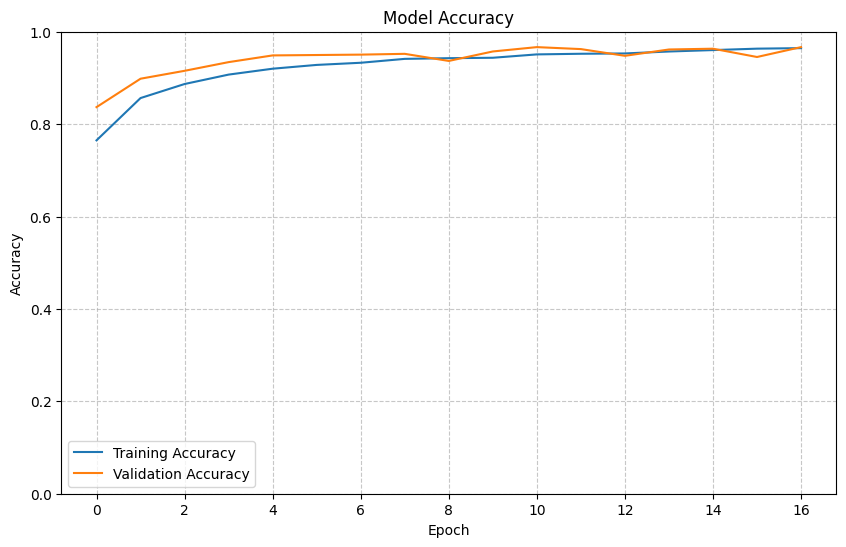

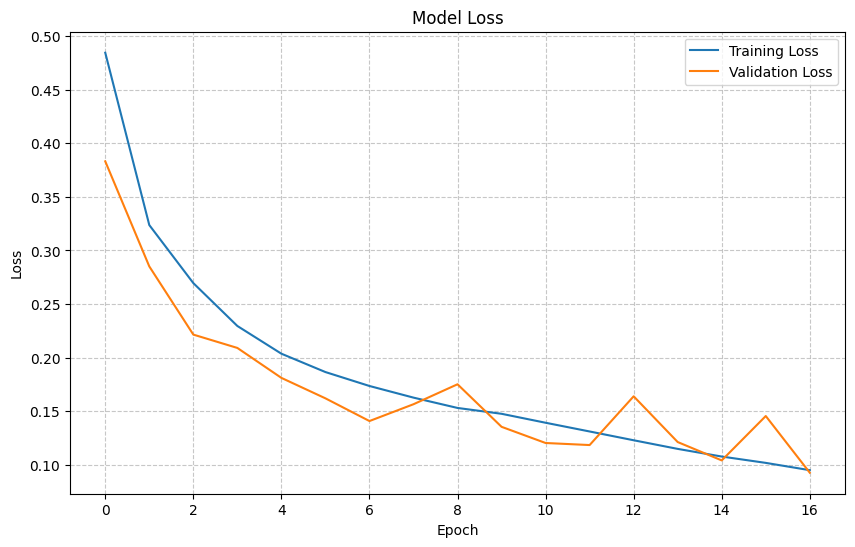

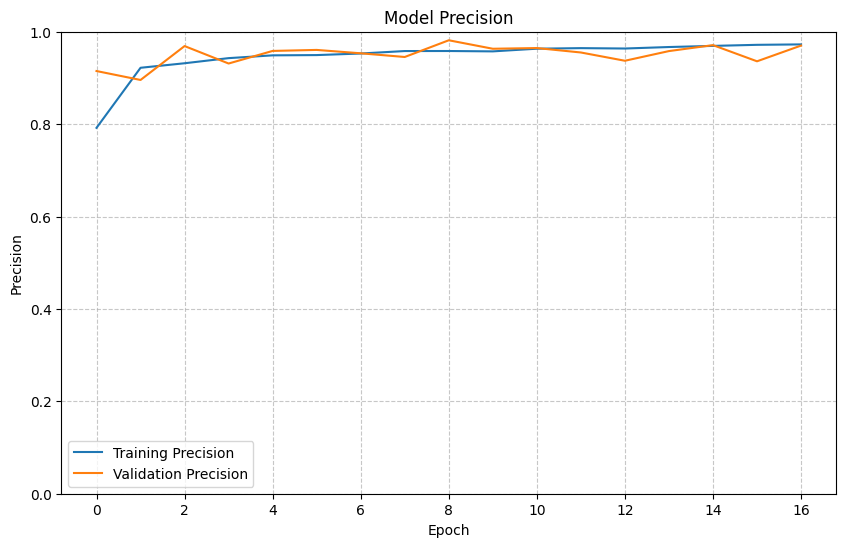

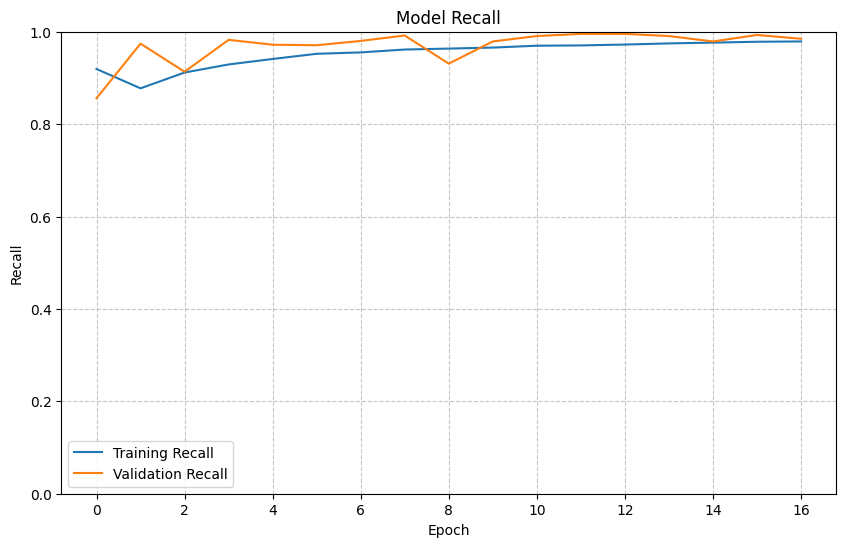

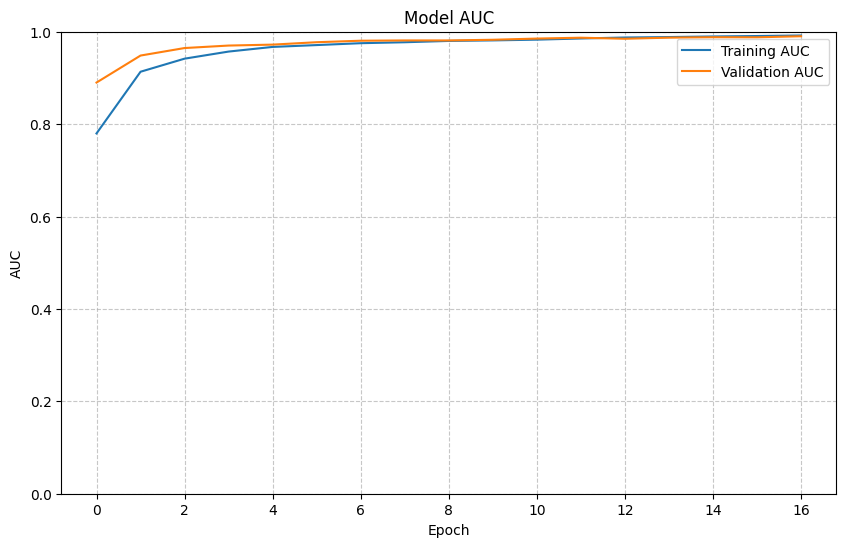

In [8]:
def plot_learning_curves(history, metric, title, ylabel, ylim=None):
    """Plot learning curves for a given metric"""
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric], label=f'Training {ylabel}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {ylabel}')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    if ylim:
        plt.ylim(ylim)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Save figure
    plt.savefig(os.path.join(experiment_dir, f"{metric}_curve.png"), dpi=300, bbox_inches='tight')
    plt.show()

# Plot accuracy
plot_learning_curves(history, 'accuracy', 'Model Accuracy', 'Accuracy', ylim=(0, 1))

# Plot loss
plot_learning_curves(history, 'loss', 'Model Loss', 'Loss')

# Plot precision
plot_learning_curves(history, 'precision', 'Model Precision', 'Precision', ylim=(0, 1))

# Plot recall
plot_learning_curves(history, 'recall', 'Model Recall', 'Recall', ylim=(0, 1))

# Plot AUC
plot_learning_curves(history, 'auc', 'Model AUC', 'AUC', ylim=(0, 1))

## 9. Model Evaluation on Test Set

In [9]:
# Evaluate model on test set
test_metrics = model.evaluate(test_generator, verbose=1)
metric_names = model.metrics_names

# Print metrics
print("\nTest Results:")
for name, value in zip(metric_names, test_metrics):
    print(f"{name}: {value:.4f}")

# Save test metrics
test_results = {name: float(value) for name, value in zip(metric_names, test_metrics)}
with open(os.path.join(experiment_dir, "test_metrics.json"), "w") as f:
    json.dump(test_results, f, indent=4)

220/220 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9340 - auc: 0.7249 - loss: 0.1453 - precision: 0.6457 - recall: 0.7082

Test Results:
loss: 0.1080
compile_metrics: 0.9545


## 10. Detailed Classification Metrics

In [14]:
# Generate predictions
test_generator.reset()
pred_probs = model.predict(test_generator, verbose=1)
pred_classes = (pred_probs > 0.7).astype(int).flatten()

# True labels
true_classes = test_generator.classes

# Classification report
report = classification_report(true_classes, pred_classes, 
                              target_names=class_names, 
                              output_dict=True)
print(classification_report(true_classes, pred_classes, target_names=class_names))

# Save classification report
with open(os.path.join(experiment_dir, "classification_report.json"), "w") as f:
    json.dump(report, f, indent=4)

# Also save as text
with open(os.path.join(experiment_dir, "classification_report.txt"), "w") as f:
    f.write(classification_report(true_classes, pred_classes, target_names=class_names))

220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step
              precision    recall  f1-score   support

      NORMAL       0.89      0.94      0.91       476
   PNEUMONIA       0.98      0.95      0.97      1284

    accuracy                           0.95      1760
   macro avg       0.93      0.95      0.94      1760
weighted avg       0.95      0.95      0.95      1760



## 11. Confusion Matrix Visualization

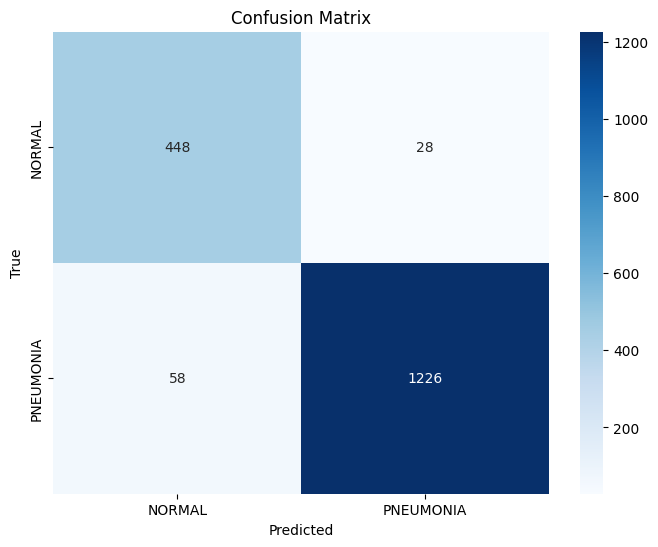

In [15]:
# Compute confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Save confusion matrix plot
confusion_matrix_path = os.path.join(experiment_dir, "confusion_matrix.png")
plt.savefig(confusion_matrix_path, dpi=300, bbox_inches='tight')
plt.show()

# Save confusion matrix as numpy array
np.save(os.path.join(experiment_dir, "confusion_matrix.npy"), cm)

## 12. ROC Curve Analysis

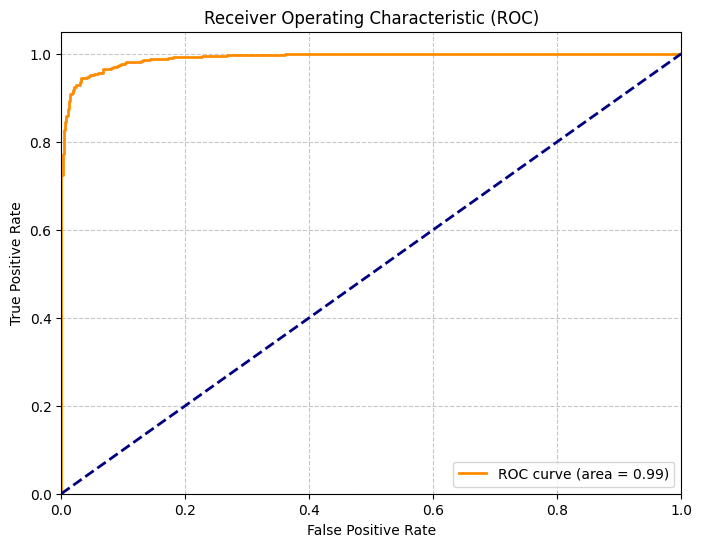

In [16]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(true_classes, pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)

# Save ROC curve
roc_curve_path = os.path.join(experiment_dir, "roc_curve.png")
plt.savefig(roc_curve_path, dpi=300, bbox_inches='tight')
plt.show()

# Save ROC data
roc_data = {
    "fpr": fpr.tolist(),
    "tpr": tpr.tolist(),
    "auc": float(roc_auc)
}
with open(os.path.join(experiment_dir, "roc_data.json"), "w") as f:
    json.dump(roc_data, f, indent=4)

## 13. Experiment Summary Report

In [17]:
print(test_results)

{'loss': 0.10795210301876068, 'compile_metrics': 0.9545454382896423}


In [18]:
# Generate a comprehensive summary report
report_path = os.path.join(experiment_dir, "experiment_summary.md")

with open(report_path, "w") as f:
    # Title
    f.write(f"# Experiment Summary: {config['experiment_name']}\n\n")
    f.write(f"Date: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    # Configuration
    f.write("## Configuration\n\n")
    f.write("### Data\n\n")
    f.write(f"- Training directory: `{config['data']['train_dir']}`\n")
    f.write(f"- Validation directory: `{config['data']['val_dir']}`\n")
    f.write(f"- Test directory: `{config['data']['test_dir']}`\n")
    f.write(f"- Image size: {config['data']['img_size']}\n")
    f.write(f"- Batch size: {config['data']['batch_size']}\n\n")
    
    f.write("### Model Architecture\n\n")
    f.write(f"- Model type: {config['model']['name']}\n")
    f.write(f"- Input shape: {config['model']['input_shape']}\n")
    # f.write(f"- Convolutional layers: {config['model']['conv_layers']}\n")
    # f.write(f"- Dense layers: {config['model']['dense_layers']}\n")
    # f.write(f"- Dropout rate: {config['model']['dropout_rate']}\n\n")
    
    f.write("### Training Parameters\n\n")
    f.write(f"- Learning rate: {config['training']['learning_rate']}\n")
    f.write(f"- Epochs: {config['training']['epochs']}\n")
    f.write(f"- Early stopping: {config['training']['use_early_stopping']}\n\n")
    
    # Results summary
    f.write("## Results\n\n")
    
    # Test metrics
    f.write("### Test Metrics\n\n")
    for name, value in test_results.items():
        f.write(f"- {name}: {value:.4f}\n")
    f.write("\n")
    
    # Classification metrics
    f.write("### Classification Report\n\n")
    f.write("```\n")
    f.write(classification_report(true_classes, pred_classes, target_names=class_names))
    f.write("```\n\n")
    
    # Confusion matrix summary
    f.write("### Confusion Matrix\n\n")
    f.write(f"- True Negatives: {cm[0][0]}\n")
    f.write(f"- False Positives: {cm[0][1]}\n")
    f.write(f"- False Negatives: {cm[1][0]}\n")
    f.write(f"- True Positives: {cm[1][1]}\n\n")
    
    # ROC AUC
    f.write(f"### ROC AUC: {roc_auc:.4f}\n\n")
    
    # Image paths
    f.write("## Generated Visualizations\n\n")
    f.write(f"- Accuracy curve: `accuracy_curve.png`\n")
    f.write(f"- Loss curve: `loss_curve.png`\n")
    f.write(f"- Precision curve: `precision_curve.png`\n")
    f.write(f"- Recall curve: `recall_curve.png`\n")
    f.write(f"- AUC curve: `auc_curve.png`\n")
    f.write(f"- Confusion matrix: `confusion_matrix.png`\n")
    f.write(f"- ROC curve: `roc_curve.png`\n\n")
    
    # Analysis
    f.write("## Preliminary Analysis\n\n")
    
    # Check for overfitting
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    acc_diff = train_acc - val_acc
    
    if acc_diff > 0.1:
        f.write("**Potential overfitting detected:** Training accuracy is significantly higher than validation accuracy.\n")
        f.write("Consider adding more regularization, data augmentation, or reducing model complexity.\n\n")
    else:
        f.write("**No significant overfitting detected.** The model generalizes well from training to validation data.\n\n")
    
    # Class imbalance analysis
    if cm[0][0] + cm[0][1] > cm[1][0] + cm[1][1] * 2 or cm[1][0] + cm[1][1] > (cm[0][0] + cm[0][1]) * 2:
        f.write("**Class imbalance detected:** Consider using class weights, balanced sampling, or SMOTE.\n\n")
    
    # Performance interpretation
    f.write("### Performance Interpretation\n\n")
    
    # if test_results['precision'] < 0.7:
    #     f.write("- **Precision is low:** Model has many false positives. Consider tuning the classification threshold.\n")
    
    # if test_results['recall'] < 0.7:
    #     f.write("- **Recall is low:** Model is missing many positive cases. Consider focusing on reducing false negatives.\n")
    
    # if test_results['accuracy'] > 0.85:
    #     f.write("- **Good overall accuracy:** Model performs well on the test set.\n")
    # elif test_results['accuracy'] < 0.7:
    #     f.write("- **Low accuracy:** Model needs significant improvement.\n")
    
    # Recommendations
    f.write("\n## Recommendations for Improvement\n\n")
    f.write("Based on the results, consider the following improvements:\n\n")
    
    recommendations = []
    
    if acc_diff > 0.1:
        recommendations.append("Add more regularization (increase dropout rate or add L2 regularization)")
        recommendations.append("Implement data augmentation for training set")
    
    # if test_results['accuracy'] < 0.8:
    #     recommendations.append("Try a deeper network architecture")
    #     recommendations.append("Experiment with different learning rates")
    #     recommendations.append("Increase training time (more epochs)")
    
    # if test_results['precision'] < 0.7 or test_results['recall'] < 0.7:
    #     recommendations.append("Tune the classification threshold (currently at 0.5)")
    #     recommendations.append("Implement class weighting if classes are imbalanced")
    
    for i, rec in enumerate(recommendations, 1):
        f.write(f"{i}. {rec}\n")

print(f"Experiment summary saved to {report_path}")

Experiment summary saved to experiment_results/vgg_17e_with_class_weights_20250528_205555/experiment_summary.md


## 14. Sample Predictions Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step


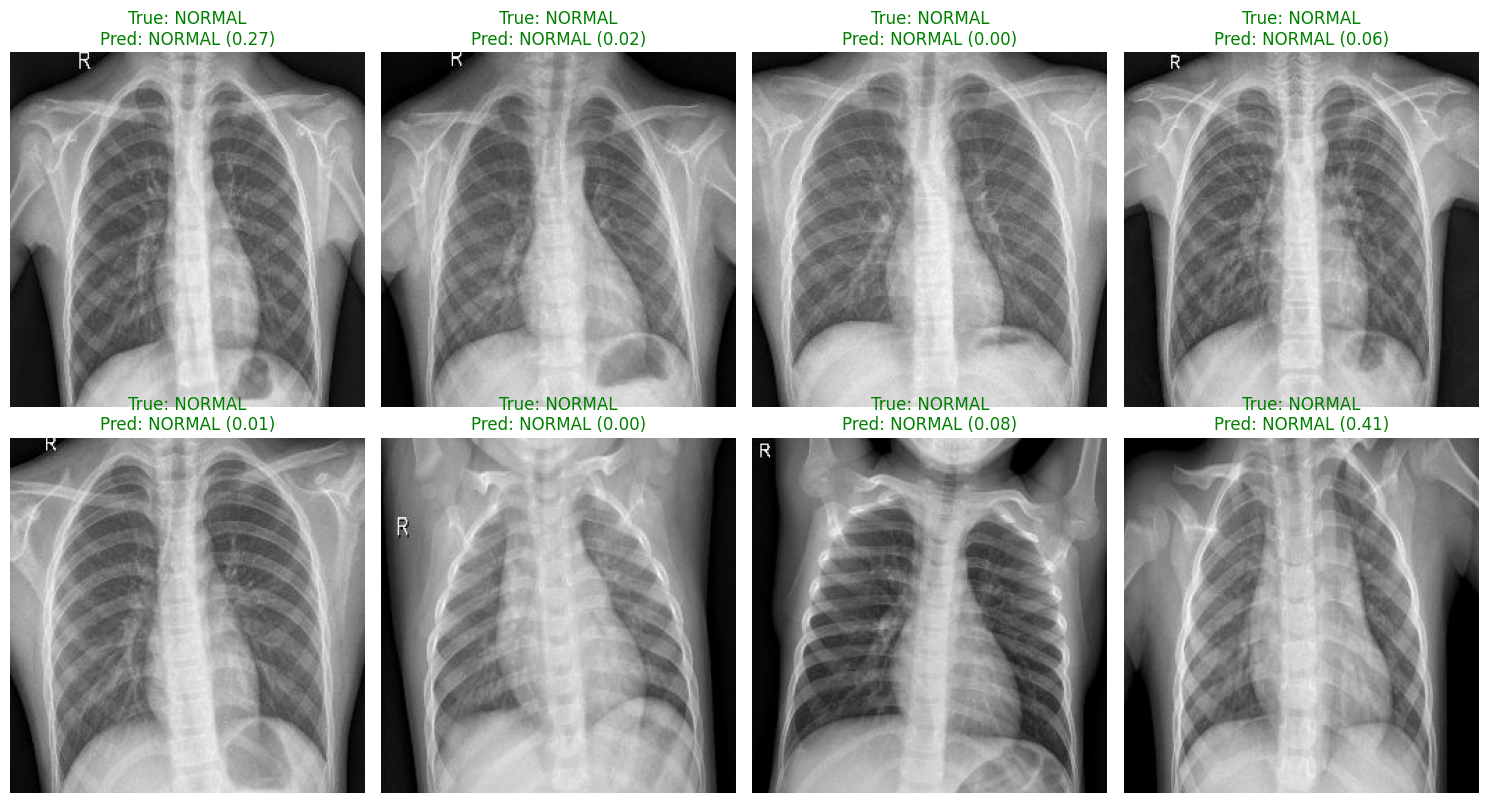

In [19]:
def visualize_predictions(model, generator, num_samples=8):
    """Visualize sample predictions from the model"""
    # Reset generator and get a batch of samples
    generator.reset()
    for images, labels in generator:
        # Get predictions
        preds = model.predict(images)
        pred_classes = (preds > 0.5).astype(int).flatten()
        
        # Prepare plot
        fig, axes = plt.subplots(2, 4, figsize=(15, 8))
        axes = axes.flatten()
        
        # Plot samples
        for i, ax in enumerate(axes):
            if i < num_samples:
                # Display image
                ax.imshow(images[i])
                
                # Determine prediction correctness
                true_label = class_names[int(labels[i])]
                pred_label = class_names[pred_classes[i]]
                confidence = preds[i][0]
                
                if labels[i] == pred_classes[i]:
                    title_color = 'green'
                else:
                    title_color = 'red'
                
                # Add labels
                ax.set_title(f"True: {true_label}\nPred: {pred_label} ({confidence:.2f})", 
                             color=title_color)
                ax.axis('off')
        
        plt.tight_layout()
        
        # Save figure
        sample_predictions_path = os.path.join(experiment_dir, "sample_predictions.png")
        plt.savefig(sample_predictions_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        break  # Only process one batch

# Visualize some predictions
visualize_predictions(model, test_generator)

## 15. Conclusion

This notebook provides a comprehensive framework for developing, training, and evaluating deep learning models for chest X-ray classification. The key features include:

1. **Organized workflow** from data loading to model evaluation
2. **Centralized configuration** for easy experiment management
3. **Multiple model architectures** for comparison
4. **Comprehensive evaluation metrics** for thorough model assessment
5. **Automatic result storage** for reproducibility and tracking
6. **Detailed visualization** of model performance
7. **Experiment summaries** for easy comparison between model variations

To improve model performance further, consider:
- Using transfer learning with pre-trained models like ResNet, DenseNet, or EfficientNet
- Implementing more advanced data augmentation techniques
- Exploring ensemble methods to combine multiple models
- Implementing Grad-CAM or similar techniques for model interpretability